# Covid-19 analysis

**This project follows CRISP process**

1. Business Understanding
2. Data Understanding
3. Prepare Data
4. Data Modeling
5. Evaluate the Results


# Business Understanding

This project aims at Solving and understanding the issue of Covid-19 precautions.

* Title: Uncovering the Secrets Behind Covid-19 Precautions: A Rehash or Truly a Matter?
* Subtitle: Let data speak for themselves through data science ways
* Three main considerations:
  * Overall, what are patterns of people’s precautions against Covid-19?
  * Does region, culture, or social norms related to such patterns?
  * What precaution is the most efficacious way?

# Data Understanding and Prepare the Data

In [1]:
# using colab thus change to the directory where files are
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount=True)

try:
  os.chdir('/content/gdrive/My Drive/Nano/dsnano/ds-hub/Project 1 - Data Science Blog')
except:
  print("can't find directory")

Mounted at /content/gdrive


#### Importing and downloading libraries

In [2]:
# Importing neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from xgboost import plot_importance

#### Read Data

The dataset is a [Kaggle dataset](https://www.kaggle.com/c/ml2021spring-hw1/data) reduced [from Delphi Epidata @ CMU](https://cmu-delphi.github.io/delphi-epidata/symptom-survey/).

In [5]:
covid = pd.read_csv("data/covid.csv")

In [6]:
covid.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,IL,IN,IA,KS,KY,LA,MD,MA,MI,MN,MS,MO,NE,NV,NJ,NM,NY,NC,OH,OK,OR,PA,RI,SC,TX,UT,VA,WA,WV,...,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.000647,53.439316,43.279629,19.586492,0.838995,0.807766,25.679101,21.280270,84.005294,13.467716,36.637887,63.318650,23.688882,44.385166,16.463551,1.664819,15.299228,12.051505,16.552264,53.256795,43.622728,20.151838,0.897801,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.552264,53.256795,43.622728,20.151838,0.897801,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116843,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.506973,54.185521,42.665766,21.292911,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116843,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656,0.947513,0.968764,26.350501,21.109971,83.819531,12.452336,36.270021,61.294809,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.273294,53.637069,42.972417,21.166656,0.947513,0.968764,26.350501,21.109971,83.819531,12.452336,36.270021,61.294809,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607,0.883833,0.893020,26.480624,21.003983,84.049437,12.224644,35.380198,60.664482,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [7]:
covid.columns

Index(['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL',
       'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE',
       'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli',
       'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state',
       'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event',
       'public_transit', 'anxious', 'depressed', 'felt_isolated',
       'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1',
       'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1',
       'travel_outside_state.1', 'work_outside_home.1', 'shop.1',
       'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1',
       'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1',
       'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2',
       'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wea

We can find that the dataset is composed of:
* States (40, encoded to one-hot vectors) 
  * e.g. AL, AK, AZ, ...
* COVID-like illness (4) (C)
  * e.g. cli,ili (influenza-like illness), ...
* Behavior Indicators (8) (B)
  * e.g. wearing_mask, travel_outside_state, ...
* Mental Health Indicators (5) (M) 
  * e.g. anxious, depressed, ...
* Tested Positive Cases (1)

The last 4 types of indicators are repeat measured for 3 times.

In [8]:
# to prevent truncation of output
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

print_full(covid.dtypes)

id                          int64
AL                        float64
AK                        float64
AZ                        float64
AR                        float64
CA                        float64
CO                        float64
CT                        float64
FL                        float64
GA                        float64
ID                        float64
IL                        float64
IN                        float64
IA                        float64
KS                        float64
KY                        float64
LA                        float64
MD                        float64
MA                        float64
MI                        float64
MN                        float64
MS                        float64
MO                        float64
NE                        float64
NV                        float64
NJ                        float64
NM                        float64
NY                        float64
NC                        float64
OH            

#### Clean Data

This part aims at cleaning data such as checking missing values or making data independent. Moreover, I create proper data which suits for following analyses.

In [9]:
def clean_data(df):
  """
  Return cleaned datasets only with combined/mean C, B, and M indicators 
  
  INPUTS:
      covid_df - dataframe for covid consequtive 3 days data
  OUTPUTS:
      covid_df - cleaned dataframe for covid revised data and last test data 
  """
  # skip states + id
  offset = 41
  
  for key, column in enumerate(df.columns):
    
    # check is in C, B, M indicators and do mean
    if offset <= key < offset+17:
      # adjust behavioral indicators and column names
      column_name = 'not_'+column+'#' if offset+5 <= key <= offset+11 else column+'#'
      df[column_name] = ((df.iloc[:, key] + df.iloc[:, key+18] + df.iloc[:, key+18*2])/3)
    
  # using test positive 2 as outcome variable
  df["test_positive"] = df["tested_positive.2"]
  
  # drop redundent columns
  df = df.drop(df.columns[41:95],axis=1,inplace=False)

  # drop id
  df = df.drop('id',axis=1,inplace=False)

  # renaming
  df = df.rename(columns=lambda x: re.sub('_',' ',x))
  df = df.rename(columns=lambda x: re.sub('#','',x))

  return df

In [10]:
covid_new = clean_data(covid)
covid_new

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,IL,IN,IA,KS,KY,LA,MD,MA,MI,MN,MS,MO,NE,NV,NJ,NM,NY,NC,OH,OK,OR,PA,RI,SC,TX,UT,VA,WA,WV,WI,cli,ili,hh cmnty cli,nohh cmnty cli,wearing mask,not travel outside state,not work outside home,not shop,not restaurant,not spent time,not large event,not public transit,anxious,depressed,felt isolated,worried become ill,worried finances,test positive
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850469,0.822339,25.796184,21.342055,84.362861,13.322934,36.528949,62.964094,23.778804,44.180548,16.520669,1.661239,15.400957,12.061156,16.751666,53.562554,43.502195,20.704935
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.903213,0.887052,25.831244,21.266770,84.192595,13.029426,36.494521,62.592568,23.728089,43.670634,16.246155,1.636439,15.312913,11.983080,16.587108,53.811288,43.297574,21.292911
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.941983,0.938823,25.920549,21.153946,84.189474,12.853079,36.620085,62.191966,23.696456,43.329645,16.144961,1.640674,15.452240,12.084551,16.494118,53.938047,43.080804,21.166656
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.958554,0.965779,26.017201,21.022660,83.983112,12.657654,36.567052,61.812056,23.284650,43.171029,15.942577,1.632472,15.414307,12.127696,16.275257,53.422938,42.848552,19.896607
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.928884,0.941621,26.259380,21.018584,83.954967,12.538552,36.221599,61.358711,22.754136,43.202577,15.639666,1.632407,15.263886,12.330432,16.151012,52.881202,43.067291,20.178428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.613629,0.620029,25.278669,20.665178,90.853304,6.937158,33.441586,50.113671,15.247162,31.364457,8.034240,1.772640,14.708409,11.253936,18.938161,67.944078,38.783844,13.008853
2696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.587166,0.598474,25.059368,20.567613,90.798094,6.953684,33.843319,49.986816,15.110734,31.037559,7.947961,1.776613,14.646539,11.272000,18.846580,67.857413,39.032545,12.725638
2697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.575191,0.588613,24.632971,20.200303,90.880293,6.783865,33.904657,49.988957,14.943488,30.683838,7.782800,1.820884,14.430657,11.202660,18.661659,67.870536,38.961700,12.613441
2698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.579844,0.593147,24.141825,19.783273,90.910735,6.764892,33.650352,49.854275,14.783310,30.544431,7.728950,1.898379,14.361278,11.258356,18.792334,67.794006,38.853340,12.477227


In [11]:
# check missing data
covid_new.isnull().mean()

AL                          0.0
AK                          0.0
AZ                          0.0
AR                          0.0
CA                          0.0
CO                          0.0
CT                          0.0
FL                          0.0
GA                          0.0
ID                          0.0
IL                          0.0
IN                          0.0
IA                          0.0
KS                          0.0
KY                          0.0
LA                          0.0
MD                          0.0
MA                          0.0
MI                          0.0
MN                          0.0
MS                          0.0
MO                          0.0
NE                          0.0
NV                          0.0
NJ                          0.0
NM                          0.0
NY                          0.0
NC                          0.0
OH                          0.0
OK                          0.0
OR                          0.0
PA      

In [12]:
# check types and shapes
print_full(covid_new.dtypes)
covid_new.shape

AL                          float64
AK                          float64
AZ                          float64
AR                          float64
CA                          float64
CO                          float64
CT                          float64
FL                          float64
GA                          float64
ID                          float64
IL                          float64
IN                          float64
IA                          float64
KS                          float64
KY                          float64
LA                          float64
MD                          float64
MA                          float64
MI                          float64
MN                          float64
MS                          float64
MO                          float64
NE                          float64
NV                          float64
NJ                          float64
NM                          float64
NY                          float64
NC                          

(2700, 58)

In [13]:
covid_new.describe()

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,IL,IN,IA,KS,KY,LA,MD,MA,MI,MN,MS,MO,NE,NV,NJ,NM,NY,NC,OH,OK,OR,PA,RI,SC,TX,UT,VA,WA,WV,WI,cli,ili,hh cmnty cli,nohh cmnty cli,wearing mask,not travel outside state,not work outside home,not shop,not restaurant,not spent time,not large event,not public transit,anxious,depressed,felt isolated,worried become ill,worried finances,test positive
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.024815,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.025185,0.994714,1.019248,29.527536,24.401281,89.736428,8.862209,31.664077,55.198377,16.636024,36.178335,10.304780,2.389464,18.071329,13.067151,19.228354,64.734072,44.544013,16.431280
std,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.155589,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.156716,0.416349,0.419742,9.074415,8.434421,5.361438,3.383185,4.892585,4.505117,5.652711,6.648171,4.686235,1.049095,2.227734,1.608797,2.695024,6.217136,5.235961,7.619354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144777,0.148810,10.117738,6.967456,71.879099,1.397059,18.410263,43.407636,3.668971,22.208275,2.222450,0.781462,13.157625,8.449808,13.536948,48.489405,33.235253,2.338708
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.676707,0.704958,23.219021,18.617736,86.394032,6.173837,28.191559,51.365697,13.289077,30.711783,6.620271,1.720206,16.452007,11.933720,17.299285,59.684560,40.554932,10.327314
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.923477,0.946203,29.037318,23.901764,90.856139,8.286711,32.082544,55.095311,16.289862,36.157781,9.755857,2.209016,17.685519,12.951021,18.727792,65.771243,43.955616,15.646480
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [14]:
# standardize these columns

# create a scaler object
scaler = MinMaxScaler()

# fit and transform the data
covid_norm = pd.DataFrame(scaler.fit_transform(covid_new.iloc[:,40:58]), columns=covid_new.columns[40:58])

covid_norm

,cli,ili,hh cmnty cli,nohh cmnty cli,wearing mask,not travel outside state,not work outside home,not shop,not restaurant,not spent time,not large event,not public transit,anxious,depressed,felt isolated,worried become ill,worried finances,test positive
0,0.303650,0.286785,0.337651,0.323690,0.478386,0.708759,0.765129,0.899070,0.818155,0.775780,0.652703,0.120534,0.150530,0.359200,0.222977,0.176261,0.417578,0.475553
1,0.326346,0.314340,0.338406,0.321994,0.471861,0.691316,0.763675,0.881990,0.816091,0.757776,0.640172,0.117136,0.144622,0.351434,0.211563,0.184903,0.409256,0.490777
2,0.343028,0.336384,0.340329,0.319454,0.471742,0.680836,0.768977,0.863573,0.814804,0.745737,0.635552,0.117716,0.153971,0.361527,0.205113,0.189307,0.400440,0.487508
3,0.350158,0.347862,0.342411,0.316498,0.463834,0.669221,0.766738,0.846108,0.798050,0.740137,0.626313,0.116592,0.151426,0.365819,0.189933,0.171410,0.390993,0.454623
4,0.337392,0.337575,0.347626,0.316406,0.462755,0.662143,0.752150,0.825266,0.776467,0.741251,0.612486,0.116583,0.141332,0.385984,0.181315,0.152588,0.399890,0.461920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.201741,0.200643,0.326506,0.308448,0.727104,0.329250,0.634753,0.308297,0.471051,0.323279,0.265304,0.135796,0.104059,0.278911,0.374635,0.675932,0.225673,0.276280
2696,0.190355,0.191465,0.321783,0.306251,0.724988,0.330232,0.651718,0.302465,0.465500,0.311738,0.261365,0.136340,0.099908,0.280707,0.368283,0.672921,0.235788,0.268947
2697,0.185202,0.187266,0.312600,0.297980,0.728138,0.320140,0.654308,0.302564,0.458696,0.299249,0.253826,0.142406,0.085422,0.273810,0.355457,0.673377,0.232907,0.266042
2698,0.187204,0.189197,0.302023,0.288589,0.729305,0.319012,0.643569,0.296372,0.452179,0.294327,0.251368,0.153023,0.080766,0.279350,0.364520,0.670718,0.228500,0.262515


In [15]:
# creating latent variable
covid_norm['COVID-like illness'] = covid_norm.iloc[:, 0:4].mean(axis=1)
covid_norm['Behavior Indicators'] = covid_norm.iloc[:, 4:12].mean(axis=1)
covid_norm['Mental State'] = covid_norm.iloc[:, 12:17].mean(axis=1)

covid_norm

,cli,ili,hh cmnty cli,nohh cmnty cli,wearing mask,not travel outside state,not work outside home,not shop,not restaurant,not spent time,not large event,not public transit,anxious,depressed,felt isolated,worried become ill,worried finances,test positive,COVID-like illness,Behavior Indicators,Mental State
0,0.303650,0.286785,0.337651,0.323690,0.478386,0.708759,0.765129,0.899070,0.818155,0.775780,0.652703,0.120534,0.150530,0.359200,0.222977,0.176261,0.417578,0.475553,0.312944,0.652314,0.265309
1,0.326346,0.314340,0.338406,0.321994,0.471861,0.691316,0.763675,0.881990,0.816091,0.757776,0.640172,0.117136,0.144622,0.351434,0.211563,0.184903,0.409256,0.490777,0.325271,0.642502,0.260356
2,0.343028,0.336384,0.340329,0.319454,0.471742,0.680836,0.768977,0.863573,0.814804,0.745737,0.635552,0.117716,0.153971,0.361527,0.205113,0.189307,0.400440,0.487508,0.334799,0.637367,0.262072
3,0.350158,0.347862,0.342411,0.316498,0.463834,0.669221,0.766738,0.846108,0.798050,0.740137,0.626313,0.116592,0.151426,0.365819,0.189933,0.171410,0.390993,0.454623,0.339232,0.628374,0.253916
4,0.337392,0.337575,0.347626,0.316406,0.462755,0.662143,0.752150,0.825266,0.776467,0.741251,0.612486,0.116583,0.141332,0.385984,0.181315,0.152588,0.399890,0.461920,0.334750,0.618638,0.252222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.201741,0.200643,0.326506,0.308448,0.727104,0.329250,0.634753,0.308297,0.471051,0.323279,0.265304,0.135796,0.104059,0.278911,0.374635,0.675932,0.225673,0.276280,0.259334,0.399354,0.331842
2696,0.190355,0.191465,0.321783,0.306251,0.724988,0.330232,0.651718,0.302465,0.465500,0.311738,0.261365,0.136340,0.099908,0.280707,0.368283,0.672921,0.235788,0.268947,0.252463,0.398043,0.331521
2697,0.185202,0.187266,0.312600,0.297980,0.728138,0.320140,0.654308,0.302564,0.458696,0.299249,0.253826,0.142406,0.085422,0.273810,0.355457,0.673377,0.232907,0.266042,0.245762,0.394916,0.324195
2698,0.187204,0.189197,0.302023,0.288589,0.729305,0.319012,0.643569,0.296372,0.452179,0.294327,0.251368,0.153023,0.080766,0.279350,0.364520,0.670718,0.228500,0.262515,0.241753,0.392394,0.324771


# Data Modeling

This part aims at answering aforementioned three questions through descrptive statistics and machine leaning (especailly tree-based xgb).

#### **Q1: Patterns of Precautions During the Pandemic**

To answer this question, I used cleaned data to do descriptive analyses including checking the distribution by boxplots and checking the correlation through cor-var matrix.

**Used dataset**

In [16]:
covid_norm

,cli,ili,hh cmnty cli,nohh cmnty cli,wearing mask,not travel outside state,not work outside home,not shop,not restaurant,not spent time,not large event,not public transit,anxious,depressed,felt isolated,worried become ill,worried finances,test positive,COVID-like illness,Behavior Indicators,Mental State
0,0.303650,0.286785,0.337651,0.323690,0.478386,0.708759,0.765129,0.899070,0.818155,0.775780,0.652703,0.120534,0.150530,0.359200,0.222977,0.176261,0.417578,0.475553,0.312944,0.652314,0.265309
1,0.326346,0.314340,0.338406,0.321994,0.471861,0.691316,0.763675,0.881990,0.816091,0.757776,0.640172,0.117136,0.144622,0.351434,0.211563,0.184903,0.409256,0.490777,0.325271,0.642502,0.260356
2,0.343028,0.336384,0.340329,0.319454,0.471742,0.680836,0.768977,0.863573,0.814804,0.745737,0.635552,0.117716,0.153971,0.361527,0.205113,0.189307,0.400440,0.487508,0.334799,0.637367,0.262072
3,0.350158,0.347862,0.342411,0.316498,0.463834,0.669221,0.766738,0.846108,0.798050,0.740137,0.626313,0.116592,0.151426,0.365819,0.189933,0.171410,0.390993,0.454623,0.339232,0.628374,0.253916
4,0.337392,0.337575,0.347626,0.316406,0.462755,0.662143,0.752150,0.825266,0.776467,0.741251,0.612486,0.116583,0.141332,0.385984,0.181315,0.152588,0.399890,0.461920,0.334750,0.618638,0.252222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.201741,0.200643,0.326506,0.308448,0.727104,0.329250,0.634753,0.308297,0.471051,0.323279,0.265304,0.135796,0.104059,0.278911,0.374635,0.675932,0.225673,0.276280,0.259334,0.399354,0.331842
2696,0.190355,0.191465,0.321783,0.306251,0.724988,0.330232,0.651718,0.302465,0.465500,0.311738,0.261365,0.136340,0.099908,0.280707,0.368283,0.672921,0.235788,0.268947,0.252463,0.398043,0.331521
2697,0.185202,0.187266,0.312600,0.297980,0.728138,0.320140,0.654308,0.302564,0.458696,0.299249,0.253826,0.142406,0.085422,0.273810,0.355457,0.673377,0.232907,0.266042,0.245762,0.394916,0.324195
2698,0.187204,0.189197,0.302023,0.288589,0.729305,0.319012,0.643569,0.296372,0.452179,0.294327,0.251368,0.153023,0.080766,0.279350,0.364520,0.670718,0.228500,0.262515,0.241753,0.392394,0.324771


**visulization: boxplot**

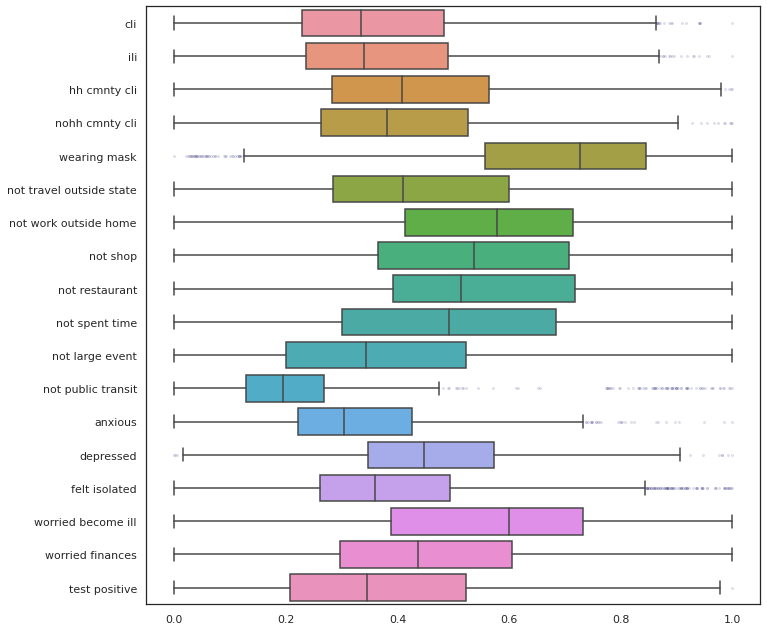

In [ ]:
sns.set_theme(style="white")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))
#plt.xlim(-3, 3)
sns.boxplot(data=covid_norm.iloc[:,:-3], orient='h', flierprops = dict(marker = 'o', markeredgecolor='navy', alpha=.1, ms=10, markersize = 2))
plt.show()

**Explain the visualisation**

Above results of boxplots of variables are somewhat answering the questions that what happened during the pandemic?

Based on the distribution of each feature shown in above box-plots, here you can see during pandemic, to prevent getting virus, people started to take precautions, largely wearing masks but less not using public transit. Regarding mental states during pandemic, it makes sense that people mostly tended to worry about being infected relative to other kinds of mental health indicators.


**visulization: correlation**

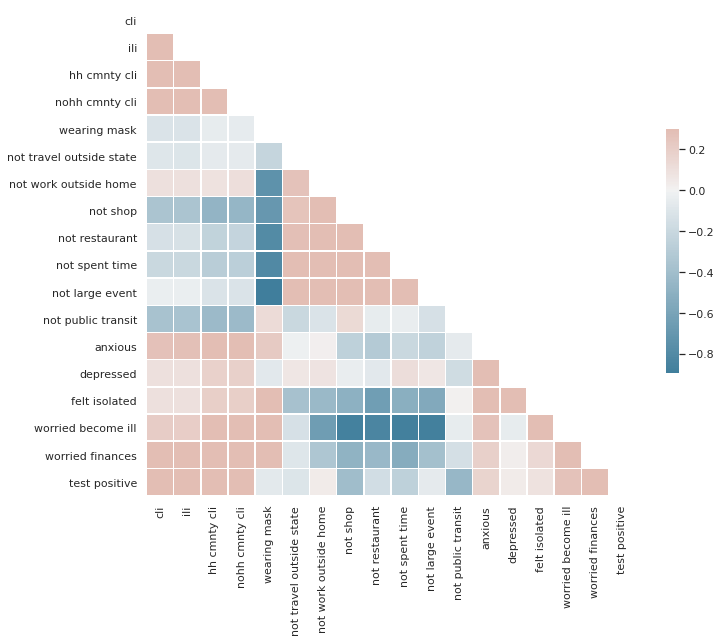

In [ ]:
sns.set_theme(style="white")

# Compute the correlation matrix
df_conti = covid_new.iloc[:, 40:]
corr = df_conti.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Explain the visualisation**

Above results of correlations of variables are somewhat answering the questions that What precaution patterns people showed?

During pandemic, those tended to take behavioral precautions were less feeling ill nor feeling worried (*obviously negative correlations, albeit not checking their significances*), indicating that wearing a mask or keeping social distance might refrain you from getting sick or being anxious. Moreover, having a check at last row of the matrix, you can see behavioral precautions are negatively correlated to being confirmed as a Covid-19 case, indicating that behavioral precautions might play a pivotal role in preventing infection.

#### **Q2: Region, Culture, or Social Norms Matters**

To answer this question, I also used cleaned data to do descriptive analyses where I create latent variable and then check and plot their pattern under each American state.

**Prepare dataset and analysis**

In [ ]:
# one-hot vector decoder
def one_hot_decoder(row):
  for c in covid_new.columns:
    if row[c]==1:
      return c

covid_norm["State"] = covid_new.apply(one_hot_decoder, axis=1)

In [ ]:
geo = covid_norm.groupby(['State']).agg({'Test positive':'mean', 'COVID-like illness':'mean', 'Behavior Indicators':'mean',	'Mental State':'mean'})

In [ ]:
geo

,Test positive,COVID-like illness,Behavior Indicators,Mental State
State,,,,
AK,0.176100,0.460875,0.469319,0.415431
AL,0.443390,0.395886,0.657824,0.278022
AR,0.402865,0.438926,0.585992,0.469575
AZ,0.164459,0.197514,0.552822,0.293161
CA,0.107338,0.123989,0.467586,0.405280
CO,0.202342,0.278837,0.573423,0.413070
CT,0.084175,0.142943,0.567279,0.346849
FL,0.215481,0.198125,0.568223,0.255498
GA,0.300661,0.280207,0.588992,0.272984


**Visulization**

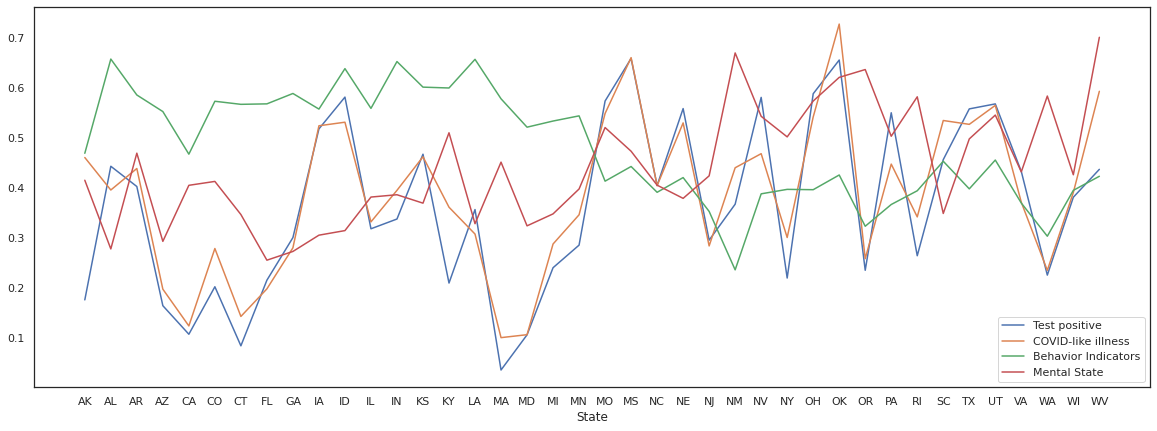

In [ ]:
# indicators and each state showcase
fig, ax = plt.subplots(figsize=(20,7))

geo.plot(ax=ax)
plt.xticks(np.arange(len(geo.index)), geo.index)
plt.show()

**Explain the visualisation**

Above results are somewhat answering the questions regarding whether region effects exist?

Although not conducting the statistical inference such as $\chi^2$ testing, I can find that states with high behavioral indicators/precautions tend to have low test positive/Covid-like illness/mental state and vice versa, which reconfirms my previous findings. More importantly, each American state has its idiosyncratic pattern different from one another, revealing that the social norm or the culture of a region may be important in Covid-19 prevention.


#### **Q3: Important Precautions to Covid-19**

To answer this question, I adopted machine learning predictive model (here I used xgboost algorithm).

**Analysis**

Define X and Y

In [ ]:
covid_new

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,IL,IN,IA,KS,KY,LA,MD,MA,MI,MN,MS,MO,NE,NV,NJ,NM,NY,NC,OH,OK,OR,PA,RI,SC,TX,UT,VA,WA,WV,WI,cli,ili,hh cmnty cli,nohh cmnty cli,wearing mask,travel outside state,work outside home,shop,restaurant,spent time,large event,public transit,anxious,depressed,felt isolated,worried become ill,worried finances,Test positive
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850469,0.822339,25.796184,21.342055,84.362861,13.322934,36.528949,62.964094,23.778804,44.180548,16.520669,1.661239,15.400957,12.061156,16.751666,53.562554,43.502195,20.704935
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.903213,0.887052,25.831244,21.266770,84.192595,13.029426,36.494521,62.592568,23.728089,43.670634,16.246155,1.636439,15.312913,11.983080,16.587108,53.811288,43.297574,21.292911
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.941983,0.938823,25.920549,21.153946,84.189474,12.853079,36.620085,62.191966,23.696456,43.329645,16.144961,1.640674,15.452240,12.084551,16.494118,53.938047,43.080804,21.166656
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.958554,0.965779,26.017201,21.022660,83.983112,12.657654,36.567052,61.812056,23.284650,43.171029,15.942577,1.632472,15.414307,12.127696,16.275257,53.422938,42.848552,19.896607
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.928884,0.941621,26.259380,21.018584,83.954967,12.538552,36.221599,61.358711,22.754136,43.202577,15.639666,1.632407,15.263886,12.330432,16.151012,52.881202,43.067291,20.178428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.613629,0.620029,25.278669,20.665178,90.853304,6.937158,33.441586,50.113671,15.247162,31.364457,8.034240,1.772640,14.708409,11.253936,18.938161,67.944078,38.783844,13.008853
2696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.587166,0.598474,25.059368,20.567613,90.798094,6.953684,33.843319,49.986816,15.110734,31.037559,7.947961,1.776613,14.646539,11.272000,18.846580,67.857413,39.032545,12.725638
2697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.575191,0.588613,24.632971,20.200303,90.880293,6.783865,33.904657,49.988957,14.943488,30.683838,7.782800,1.820884,14.430657,11.202660,18.661659,67.870536,38.961700,12.613441
2698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.579844,0.593147,24.141825,19.783273,90.910735,6.764892,33.650352,49.854275,14.783310,30.544431,7.728950,1.898379,14.361278,11.258356,18.792334,67.794006,38.853340,12.477227


In [ ]:
dtaY = covid_new['Test positive']
dtaX = covid_new.drop(["Test positive"], axis=1)

Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dtaX, dtaY, test_size=0.3, random_state=50)
print(X_train.shape, X_test.shape)

(1890, 57) (810, 57)


In [ ]:
params = {
    'max_depth': 6,
    'n_estimators': 1000,
    'subsample': 1,
    'colsample_bytree': 0.7, 
    'learning_rate': 0.01, 
    'reg_alpha': 0.1,
    'reg_lambda': 1e-05,
    'min_child_weight': 20,
    'gamma': 0.2
}

xbgreg = xgb.XGBRegressor(**params)

model = xbgreg.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)], eval_metric=["rmse"])

print("Params :", params)
print("R-squared: %.2f%%" % (model.score(X_test, y_test)))

[16:55:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:17.4549
[1]	validation_0-rmse:17.284
[2]	validation_0-rmse:17.1147
[3]	validation_0-rmse:16.9476
[4]	validation_0-rmse:16.7825
[5]	validation_0-rmse:16.6185
[6]	validation_0-rmse:16.4567
[7]	validation_0-rmse:16.297
[8]	validation_0-rmse:16.1399
[9]	validation_0-rmse:15.9828
[10]	validation_0-rmse:15.8269
[11]	validation_0-rmse:15.6723
[12]	validation_0-rmse:15.5195
[13]	validation_0-rmse:15.3701
[14]	validation_0-rmse:15.2209
[15]	validation_0-rmse:15.0725
[16]	validation_0-rmse:14.9259
[17]	validation_0-rmse:14.7809
[18]	validation_0-rmse:14.6379
[19]	validation_0-rmse:14.4959
[20]	validation_0-rmse:14.3571
[21]	validation_0-rmse:14.2172
[22]	validation_0-rmse:14.08
[23]	validation_0-rmse:13.9435
[24]	validation_0-rmse:13.8081
[25]	validation_0-rmse:13.6744
[26]	validation_0-rmse:13.5415
[27]	validation_0-rmse:13.4095
[28]	validation_0-r

The predictive performance of $R^2 = 97\%$ which is quite acceptable. Next we will check which features contributed the most.

**Visulization**

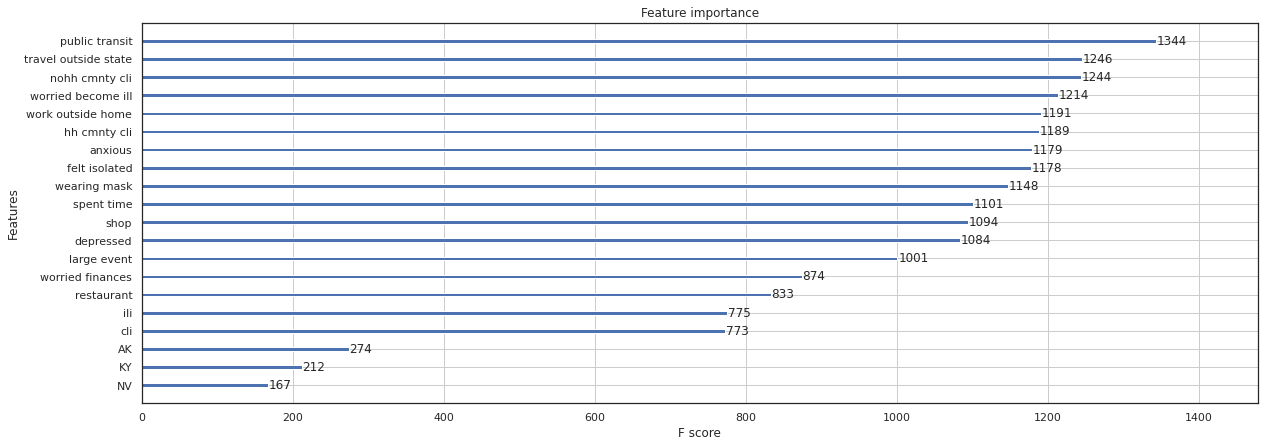

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
plot_importance(model, max_num_features=20, ax = ax)
plt.show()

**Explain the visualisation**

The model revealed behavioral precautions, among others, are crucial in prediction. The model suggested avoiding using public transit and staying at home may be the primary considerations. It is worth noting that the importance is defined by the F scores in the xgbtree.


# Evaluation

#### Findings

Overall, what are patterns of people’s precautions against Covid-19?

* During pandemic, people worried being infected and started to take behavioral precautions, such as wearing masks or keeping social distance. Those took behavioral precautions inclined to be not worried and not get infected.

Does region, culture, or social norms related to such patterns?

* Social norm or the culture of a region matters in Covid-19 prevention. Hence, beyond seen as a personal affair, putting an end to the pandemic needs everyone’s effort.

What precaution is the most efficacious way?

* Behavioral precaution plays an efficient role in refraining you from catching Covid-19. Specifically, avoiding using public transit and staying at home are the best two.

#### Limitations

Despite the fact that all questions are answered to some extent, more rigorous and refined analyses and technical reports are advised. For example, meaningful comparisons (statistical testing) can be made to explore the difference between Covid-19 patterns across American states. Moreover, due to inherent time-related characteristics, we can adopt not merely explanatory approach to apply mixed-effects model to estimate the effects but also predictive approach to apply sequence machine learning model.